## Image Augmentation in Tensorflow

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

### Data load

In [9]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 100%|██████████| 1/1 [00:06<00:00,  6.60s/ url]


Dataset tf_flowers downloaded and prepared to C:\Users\seonwook\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [10]:
num_classess = metadata.features['label'].num_classes
print(num_classess)

5


In [11]:
get_label_name = metadata.features['label'].int2str
[get_label_name(n) for n in range(5)]

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

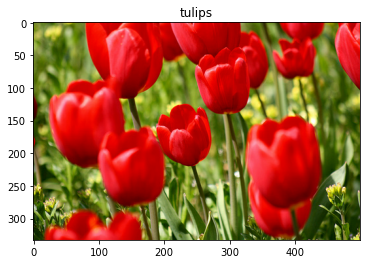

In [14]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### 크기와 비율 조절

In [15]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

- another option : Rescaling(1./127.5, offset=-1)

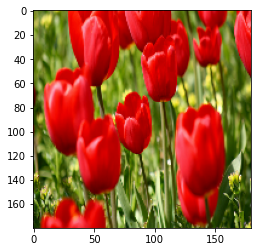

In [16]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [17]:
print('Min and max pixel values:', result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### augmentation type - data rotation

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### tf.extend_dims의 역할

In [19]:
image.shape

TensorShape([333, 500, 3])

In [20]:
# Add the image to a batch
image = tf.expand_dims(image, 0)

In [21]:
image.shape

TensorShape([1, 333, 500, 3])

### Image Augmentation Types

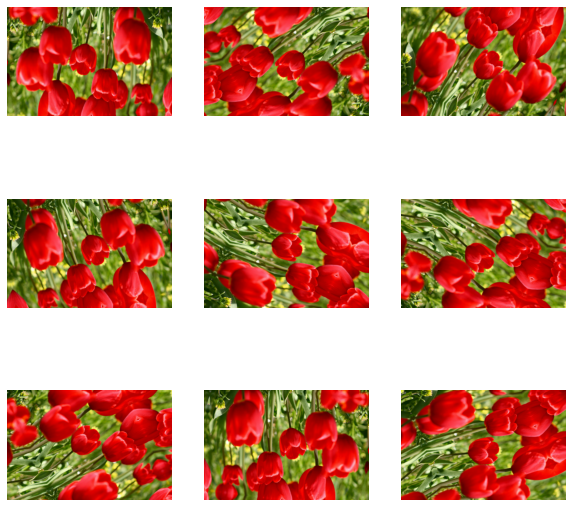

In [22]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')

### 증강을 모델에 구성 - 예시

In [23]:
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Rest of my model
])

- 데이터 증강은 나머지 레이어와 동기적으로 기기에서 실행되며 GPU 가속을 이용
- model.fit(model.evaluate 또는 model.predict가 아님) 호출 중에만 증강

### 다른 방식

In [24]:
aug_ds = train_ds.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
)

#### 데이터 증강을 위한 구성

In [25]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)
    
    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

#### 데이터 구성

In [26]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [27]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classess)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
epochs=5
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 54s 513ms/step - loss: 1.3921 - accuracy: 0.3937 - val_loss: 1.1599 - val_accuracy: 0.5504
Epoch 2/5
92/92 [==============================] - 57s 557ms/step - loss: 1.0835 - accuracy: 0.5616 - val_loss: 1.0616 - val_accuracy: 0.5559
Epoch 3/5
92/92 [==============================] - 58s 560ms/step - loss: 0.9737 - accuracy: 0.6008 - val_loss: 0.9587 - val_accuracy: 0.6349
Epoch 4/5
92/92 [==============================] - 51s 497ms/step - loss: 0.9255 - accuracy: 0.6356 - val_loss: 0.9025 - val_accuracy: 0.6294
Epoch 5/5
92/92 [==============================] - 53s 524ms/step - loss: 0.8731 - accuracy: 0.6570 - val_loss: 0.9390 - val_accuracy: 0.6349


In [30]:
loss, acc = model.evaluate(test_ds)
print('Accuracy', acc)

12/12 [==============================] - 2s 142ms/step - loss: 0.8916 - accuracy: 0.6458
Accuracy 0.6457765698432922


### 람다 레이어를 이용한 데이터 증강

In [31]:
def random_invert_img(x, p=0.5):
    if tf.random.uniform([]) < p:
        x = (255 - x)
    else:
        x
    return x

In [32]:
def random_invert(factor=0.5):
    return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

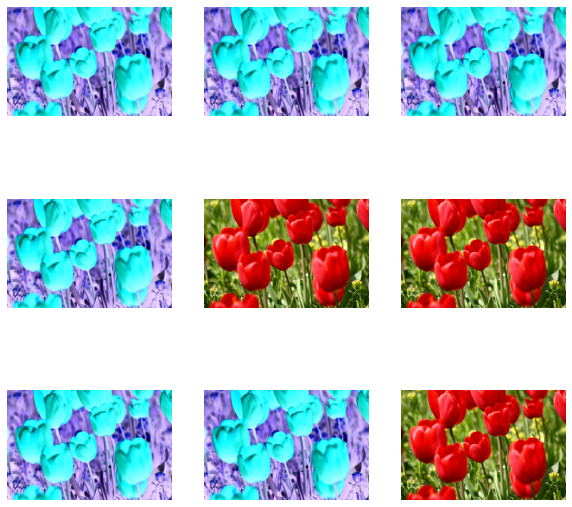

In [34]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = random_invert(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype('uint8'))
    plt.axis('off')

### 서브클래스 활용

In [35]:
class RandomInvert(layers.Layer):
    def __init__(self, factor=0.5, **kwargs):
        super().__init__(**kwargs)
        self.factor = factor
    
    def call(self, x):
        return random_invert_img(x)

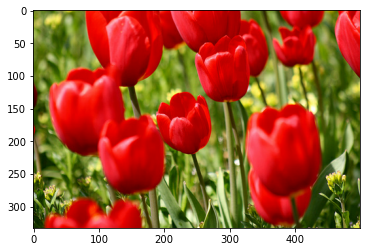

In [36]:
_ = plt.imshow(RandomInvert()(image)[0])

### 또 다른 방법

In [37]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

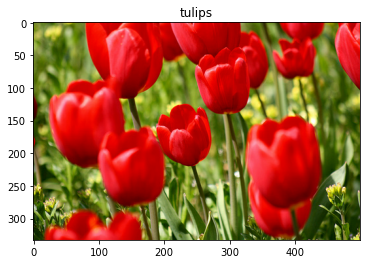

In [38]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

#### 원본과 비교 함수

In [39]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title('Augmented image')
    plt.imshow(augmented)

#### tf.image의 뒤집기

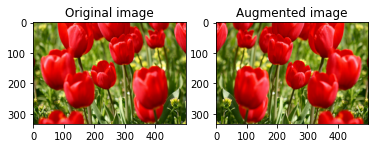

In [40]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### tf.image의 gray

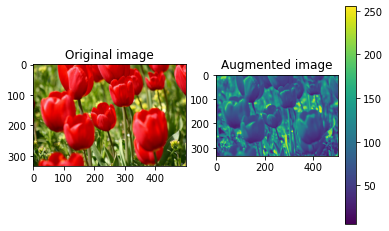

In [41]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### 체도 변화를 이용한 증강

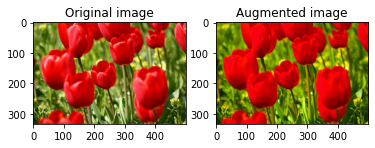

In [42]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### 밝기 변화

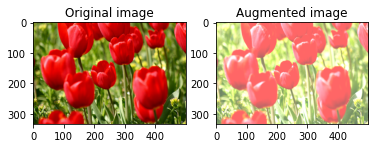

In [43]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### 이미지 자르기

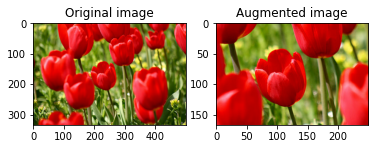

In [44]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### 90도 회전

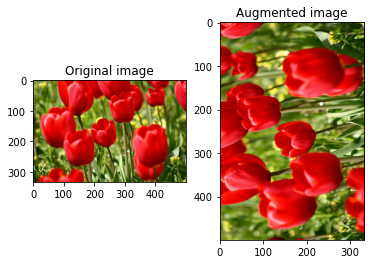

In [45]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

#### 증강 코드 함수화

In [46]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [47]:
def augment(image, label):
    image, label = resize_and_rescale(image, label)
    # Add 6 pixels of padding
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Random crop back to the original size
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0, 1)
    return image, label

#### 데이터 구성

In [48]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [49]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [50]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#### 학습 및 평가

In [51]:
model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classess)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs=5
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 81s 832ms/step - loss: 1.5233 - accuracy: 0.3685 - val_loss: 1.1327 - val_accuracy: 0.5341
Epoch 2/5
92/92 [==============================] - 91s 983ms/step - loss: 1.1521 - accuracy: 0.5201 - val_loss: 1.0718 - val_accuracy: 0.5858
Epoch 3/5
92/92 [==============================] - 87s 950ms/step - loss: 1.0023 - accuracy: 0.6066 - val_loss: 1.0443 - val_accuracy: 0.6131
Epoch 4/5
92/92 [==============================] - 86s 929ms/step - loss: 0.9352 - accuracy: 0.6349 - val_loss: 1.1179 - val_accuracy: 0.5777
Epoch 5/5
92/92 [==============================] - 86s 928ms/step - loss: 0.8375 - accuracy: 0.6703 - val_loss: 0.9710 - val_accuracy: 0.6322


In [52]:
loss, acc = model.evaluate(test_ds)
print('Accuracy', acc)

12/12 [==============================] - 2s 170ms/step - loss: 0.9507 - accuracy: 0.6376
Accuracy 0.6376021504402161
